<a href="https://colab.research.google.com/github/Pravinoraon/capstone/blob/main/Notebook%202%3A%20Model%20Training%20with%20ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras==2.14.0 tensorflow==2.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install keras==2.14.0 and tensorflow==2.15.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested keras==2.14.0
    tensorflow 2.15.0 depends on keras<2.16 and >=2.15.0

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive


In [3]:
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/bell_pepper_data/train"
val_dir = "/content/drive/MyDrive/bell_pepper_data/val"

print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))


Mounted at /content/drive
Train directory exists: True
Validation directory exists: True


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

inputs = Input(shape=(224, 224, 3))

Found 1979 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


In [6]:
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
resnet.trainable = False
resnet_features = GlobalAveragePooling2D()(resnet.output)

efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)
efficientnet.trainable = False
efficientnet_features = GlobalAveragePooling2D()(efficientnet.output)

merged_features = Concatenate()([resnet_features, efficientnet_features])
x = Dense(256, activation='relu')(merged_features)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid', dtype=tf.float32)(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 28,522,532 (108.80 MB)

 Trainable params: 885,249 (3.38 MB)

 Non-trainable params: 27,637,283 (105.43 MB)

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1114s 17s/step - accuracy: 0.5494 - loss: 0.7101 - val_accuracy: 0.5968 - val_loss: 0.6745
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 533ms/step - accuracy: 0.5909 - loss: 0.6799 - val_accuracy: 0.6048 - val_loss: 0.6624
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 36s 574ms/step - accuracy: 0.5827 - loss: 0.6772 - val_accuracy: 0.5968 - val_loss: 0.6566
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 530ms/step - accuracy: 0.5982 - loss: 0.6666 - val_accuracy: 0.6512 - val_loss: 0.6453
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 34s 547ms/step - accuracy: 0.6082 - loss: 0.6613 - val_accuracy: 0.6169 - val_loss: 0.6369
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 525ms/step - accuracy: 0.6212 - loss: 0.6588 - val_accuracy: 0.6835 - val_loss: 0.6270
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - accuracy: 0.6161 - loss: 0.6536 - val_accuracy: 0.6774 - val_loss: 0.6114
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 536ms/step - accuracy: 0.6676 - loss: 0.6233 - val_accu

In [8]:
model_save_path = "/content/drive/MyDrive/bell_pepper_data/bell_pepper_hybrid_resnet_efficientnet.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/bell_pepper_data/bell_pepper_hybrid_resnet_efficientnet.h5


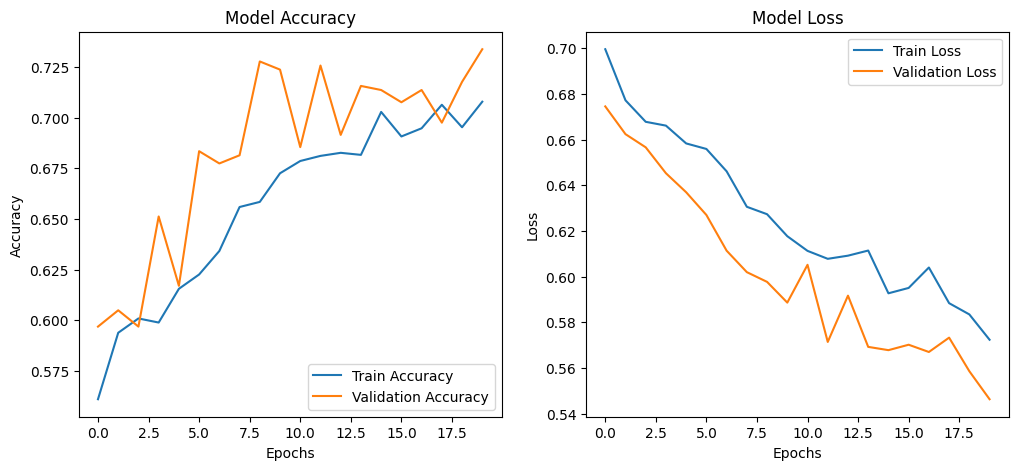

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()